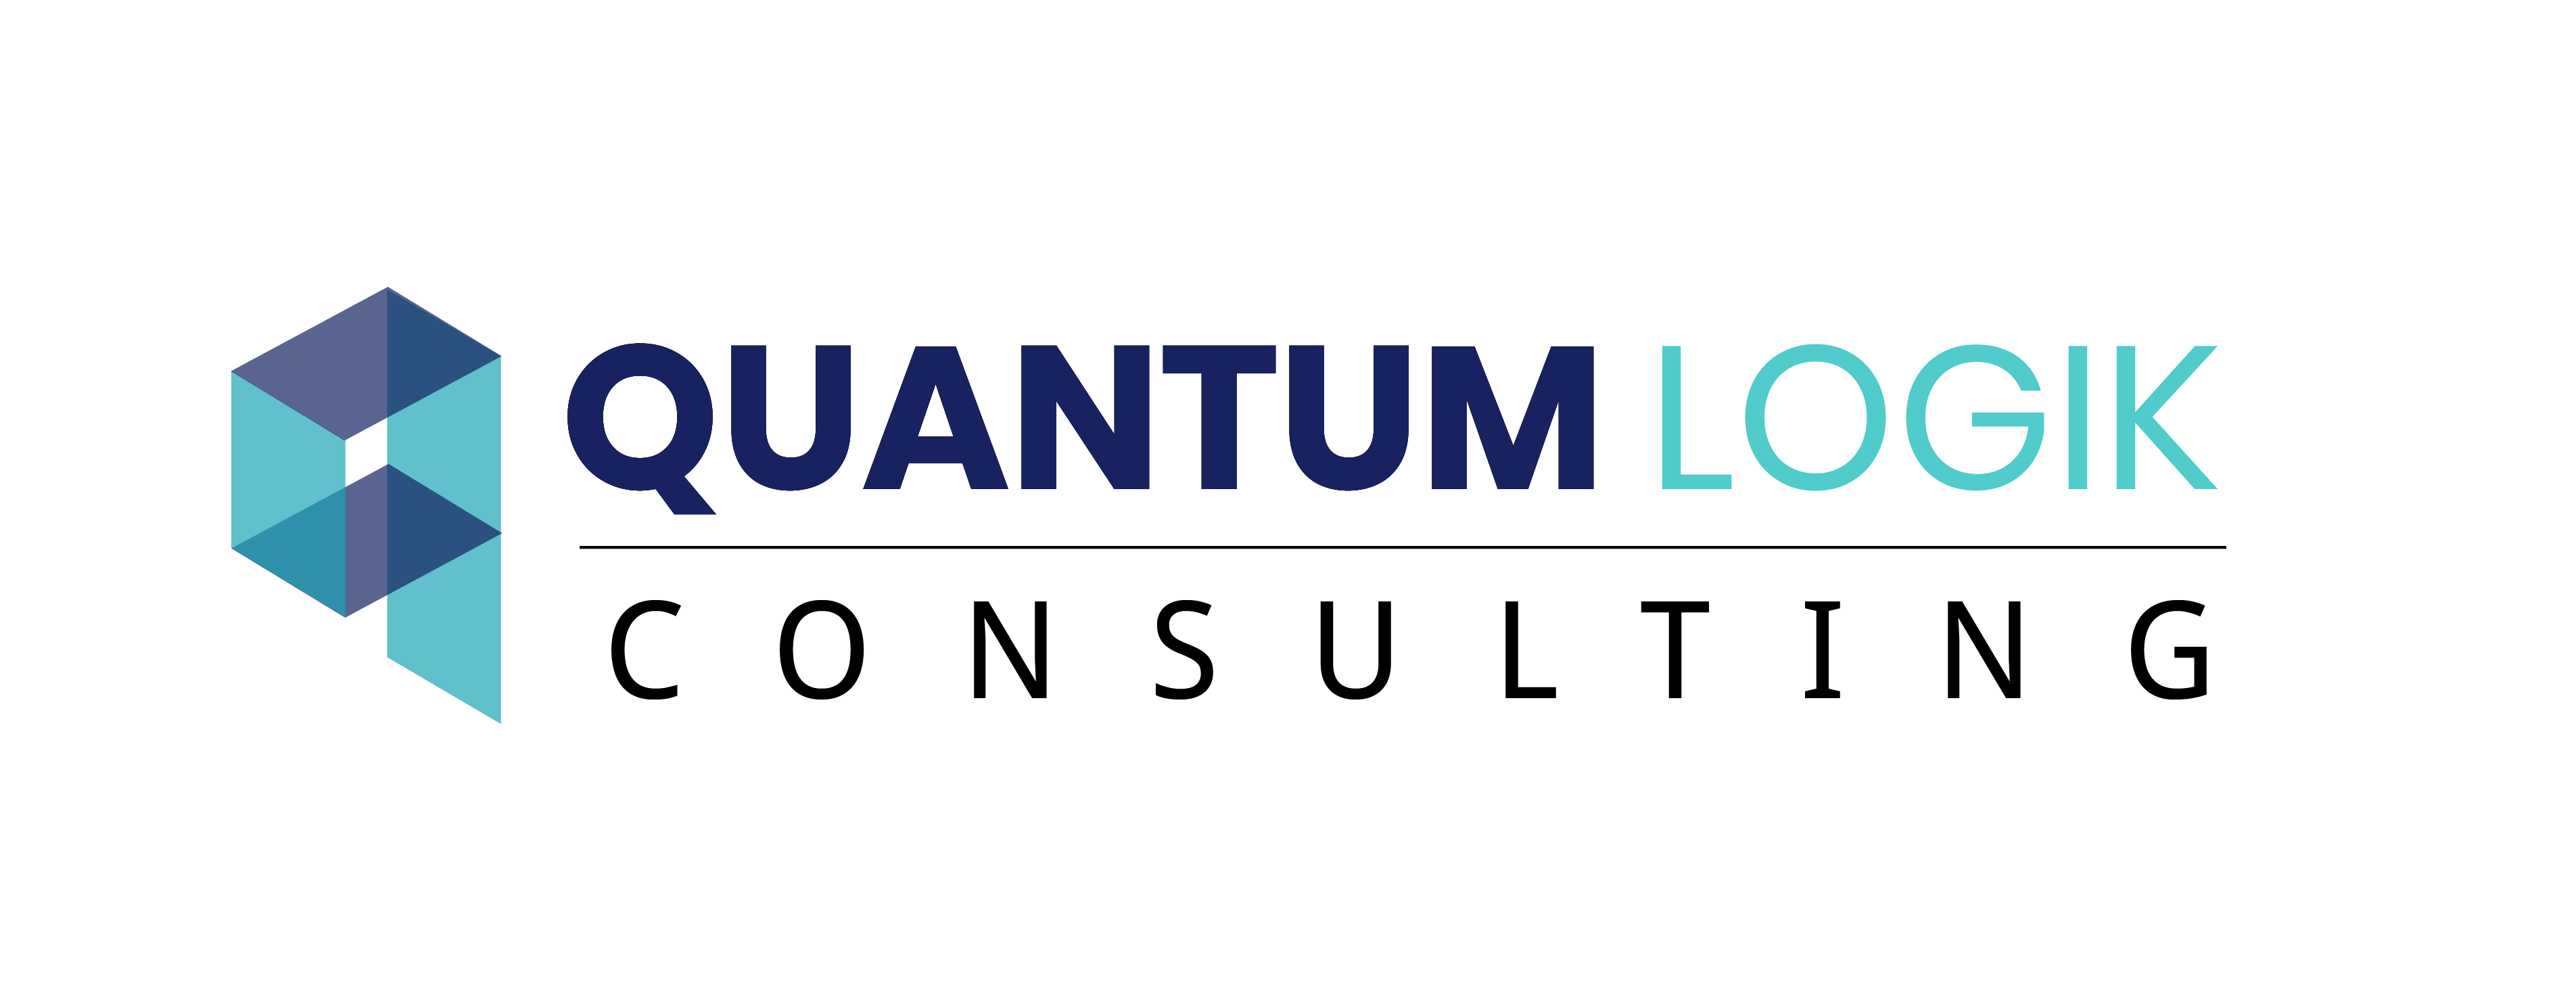

Jupyter notebook extending SimPy tutorial found at

https://realpython.com/simpy-simulating-with-python/

Highlights include:
- adding revenue and cost dimensions
- finding configuration that maximizes profit
- analysis around robustness of solution

See Readme for more

# 1.0 Introduction

## 1.1 Credits, Sources, and Inspirations

Original Tutorial
[Real Python](https://realpython.com/simpy-simulating-with-python/)

Author(s):
[Jon Mayes](https://github.com/yfMayes?tab=repositories)

Analysis
[Quantum Logik Consulting](https://quantumlogik.com/)

## 1.2 Imports and Installs

In [1]:
#import sys
#!pip install simpy

In [2]:
import simpy
import random
import statistics

import pandas as pd
import numpy

# 2.0 Classes and Functions

## 2.1 Theater Class

In [3]:
class Theater(object):
    def __init__(self, env, num_cashiers, num_servers, num_ushers):
        self.env = env
        self.cashier = simpy.Resource(env,num_cashiers)
        self.server = simpy.Resource(env, num_servers)
        self.usher = simpy.Resource(env, num_ushers)
        
    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.randint(1,3))
        
    def check_ticket(self, moviegoer):
        #note that the units are 1 and it takes 3 seconds to check a ticket
        yield self.env.timeout(3 / 60)
        
    def sell_food(self, moviegoer):
        yield self.env.timeout(random.randint(1,5))

## 2.2 Moviegoer functions

In [4]:
def go_to_movies(env, moviegoer, theater):
    #moviegoer arrives at the theater
    arrival_time = env.now
    
    #using with tells simpy to release resource when done
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
        
    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))
        
    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))
            
    #moviegoer goes into theater. wait time is over
    trial_wait_times.append(env.now - arrival_time)

## 2.3 Run the theater process

In [5]:
def run_theater(env, num_cashier, num_servers, num_ushers):
    theater = Theater(env, num_cashier, num_servers, num_ushers)
    
    #expect 3 people in line at box office open
    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))
        
    while True:
        yield env.timeout(0.20)  #wait 12 seconds
        
        moviegoer +=1
        env.process(go_to_movies(env, moviegoer, theater))
        

## 2.4 Measurement functions

In [6]:
def get_average_wait_time(wait_times):
    return statistics.mean(wait_times)
    

In [7]:
def get_average_num_customers(num_cust):
    return statistics.mean(num_cust)

## 2.5 Simulation function

In [8]:
def run_sim(num_cashiers, num_servers, num_ushers):
    #setup 
    #seed set globally so we don't just run the same sim every time   
    
    #initialize the simpy environment
    env = simpy.Environment()
    env.process(run_theater(env, num_cashiers, num_servers, num_ushers))
    
    #run for 120 simulated minutes  (make a parameter later)
    env.run(until=90)
    
    #print(wait_times)
    #return the results
    return get_average_wait_time(trial_wait_times)

# 3.0 Run the simulation

At this level, we should explore the parameter space a bit. Since it is not a huge parameter space, some intelligently applied brute force should give us a lot of insight. To be "intelligent" the key is to think intuitively about the bottlenecks in the system.  Note individual process times:

- purchase between 1 and 3 minutes
- ticket validation 3 seconds 
- food selling .5 - 2.5 minutes 
- moviegoers arrive at the box office every 12 seconds (5 per minute)

---

1. One way we will extend upon the tutorial is looking at the number of moviegoers processed. Wait time is cool, but what really matters is getting people to pay for a ticket, and hopefully, buy some favorably priced concessions.

2. Note that as set up, we have 5 people arriving per minute. As I've extended the time from 90 minutes to 120 minutes, this means 600 people show up to see our movie.


In [9]:
sim_results = []

#note, do not set a universal seed within the runs else you just make a bunch of identical runs
random.seed(311)  #i love douglas adams as much as the next nerd but...

runs_per_config = 30

max_cashiers = 20
max_servers = 20
max_ushers = 10


In [10]:
for cashiers in range(1,max_cashiers+1):
    for servers in range(1,max_servers+1):
        for ushers in range(1,max_ushers+1):
            #initialize wait_times for this config
            config_wait_times = []
            config_num_customers = []
            
            for runs in range(1, runs_per_config+1):
                #(re-)initialize wait_times
                #initialize this trials wait times
                trial_wait_times = []

                #run the sim, returning average wait time and number of customers    
                trial_avg_wait = run_sim(cashiers, servers, ushers)
                #append to the configuration arrays so we can calculate over config
                
                #append the results
                config_wait_times.append(trial_avg_wait)
                config_num_customers.append(len(trial_wait_times))
                
            
            #now do the configuration aggregates and append to sim results    
            
            avg_wait = get_average_wait_time(config_wait_times)
            avg_num_cust = get_average_num_customers(config_num_customers)
                
            this_result = (cashiers, servers, ushers, avg_wait, avg_num_cust)
            sim_results.append(this_result)
 

In [11]:
#dump results into a dataframe
cols = ['cashiers', 'servers', 'ushers', 'avg_wait', 'num_customers']

sim_results_df = pd.DataFrame(sim_results, columns=cols)

sim_results_df.tail()

,cashiers,servers,ushers,avg_wait,num_customers
3995,20,20,6,3.511895,434.933333
3996,20,20,7,3.482714,435.533333
3997,20,20,8,3.495699,434.400000
3998,20,20,9,3.552028,434.400000
3999,20,20,10,3.497211,434.666667


# 4.0 Apply business considerations and recommendations

## 4.1 Financial assumptions

To make this more concrete, let's add some businessconsiderations to the simulation.

- Average spend per moviegoer is 18 (the more advanced version will break this up into admission and concession)
- Cashiers cost 40 = 20 per hour x 2 hours
- Servers cost 35 = 17.5 per hour x 2 hours
- Ushers cost 30 = 15 per hour x 2 hours



In [12]:
rev_per_customer = 18

cost_cashier = 40
cost_server = 35
cost_usher = 30


## 4.2 Financial calculations

In [13]:
sim_results_df['revenue'] = sim_results_df['num_customers'] * rev_per_customer

sim_results_df['cost_cashiers'] = sim_results_df['cashiers'] * cost_cashier
sim_results_df['cost_servers'] = sim_results_df['servers'] * cost_server
sim_results_df['cost_ushers'] = sim_results_df['ushers'] * cost_usher

sim_results_df['cost_labor'] = (sim_results_df['cost_cashiers'] 
                                + sim_results_df['cost_servers']
                                + sim_results_df['cost_ushers'])


In [14]:
sim_results_df['profit'] = sim_results_df['revenue'] - sim_results_df['cost_labor']

In [15]:
sim_results_df.head()

,cashiers,servers,ushers,avg_wait,num_customers,revenue,cost_cashiers,cost_servers,cost_ushers,cost_labor,profit
0,1,1,1,42.363407,43.433333,781.8,40,35,30,105,676.8
1,1,1,2,42.336855,43.033333,774.6,40,35,60,135,639.6
2,1,1,3,42.542586,42.800000,770.4,40,35,90,165,605.4
3,1,1,4,43.376735,44.033333,792.6,40,35,120,195,597.6
4,1,1,5,42.641405,43.300000,779.4,40,35,150,225,554.4


## 4.3 Profit and revenue analysis

For a quick analysis, sort by profit descending and show the top 25 results

In [16]:
sim_results_df.sort_values(by=['profit'], ascending=False).head(25)


,cashiers,servers,ushers,avg_wait,num_customers,revenue,cost_cashiers,cost_servers,cost_ushers,cost_labor,profit
2080,11,9,1,3.716595,433.166667,7797.0,440,315,30,785,7012.0
2070,11,8,1,4.113913,430.533333,7749.6,440,280,30,750,6999.6
2090,11,10,1,3.629757,433.233333,7798.2,440,350,30,820,6978.2
2071,11,8,2,4.196051,430.833333,7755.0,440,280,60,780,6975.0
2280,12,9,1,3.715043,433.200000,7797.6,480,315,30,825,6972.6
1880,10,9,1,4.358179,428.666667,7716.0,400,315,30,745,6971.0
2081,11,9,2,3.777309,432.300000,7781.4,440,315,60,815,6966.4
2091,11,10,2,3.595421,434.233333,7816.2,440,350,60,850,6966.2
2100,11,11,1,3.634304,434.166667,7815.0,440,385,30,855,6960.0
2270,12,8,1,4.126939,430.333333,7746.0,480,280,30,790,6956.0


Let's do the same, but for revenue (and profit as a tiebreaker) just to compare

In [17]:
sim_results_df.sort_values(by=['revenue', 'profit'], ascending=False).head(25)

,cashiers,servers,ushers,avg_wait,num_customers,revenue,cost_cashiers,cost_servers,cost_ushers,cost_labor,profit
2990,15,20,1,3.524251,435.900000,7846.2,600,700,30,1330,6516.2
3361,17,17,2,3.515831,435.633333,7841.4,680,595,60,1335,6506.4
3537,18,14,8,3.497961,435.633333,7841.4,720,490,240,1450,6391.4
3996,20,20,7,3.482714,435.533333,7839.6,800,700,210,1710,6129.6
2960,15,17,1,3.537148,435.500000,7839.0,600,595,30,1225,6614.0
3165,16,17,6,3.496424,435.500000,7839.0,640,595,180,1415,6424.0
3949,20,15,10,3.486659,435.500000,7839.0,800,525,300,1625,6214.0
3562,18,17,3,3.519820,435.466667,7838.4,720,595,90,1405,6433.4
2975,15,18,6,3.487470,435.466667,7838.4,600,630,180,1410,6428.4
3579,18,18,10,3.473116,435.466667,7838.4,720,630,300,1650,6188.4


## 4.4 Conclusions and recommendations

### 4.4.1 Maximum customers

A reasonable maximum expectation the total number of customers within this time frame is 435. See the run below where use 1000, 1000, 100. We still can get only 435 customers through. Seeing that our space (20,20,10) has many values at 435 tells me that a reasonably best configuration is in our set

In [19]:
trial_wait_times = []
trial_avg_wait = run_sim(1000, 1000, 1000)
len(trial_wait_times)

print(trial_avg_wait, len(trial_wait_times))

3.5902298850574694 435


### 4.4.2 Best Configuration

Let's look at the the top 10 expected profit configurations.

In [20]:
sim_results_df.sort_values(by=['profit'], ascending=False).head(10)

,cashiers,servers,ushers,avg_wait,num_customers,revenue,cost_cashiers,cost_servers,cost_ushers,cost_labor,profit
2080,11,9,1,3.716595,433.166667,7797.0,440,315,30,785,7012.0
2070,11,8,1,4.113913,430.533333,7749.6,440,280,30,750,6999.6
2090,11,10,1,3.629757,433.233333,7798.2,440,350,30,820,6978.2
2071,11,8,2,4.196051,430.833333,7755.0,440,280,60,780,6975.0
2280,12,9,1,3.715043,433.200000,7797.6,480,315,30,825,6972.6
1880,10,9,1,4.358179,428.666667,7716.0,400,315,30,745,6971.0
2081,11,9,2,3.777309,432.300000,7781.4,440,315,60,815,6966.4
2091,11,10,2,3.595421,434.233333,7816.2,440,350,60,850,6966.2
2100,11,11,1,3.634304,434.166667,7815.0,440,385,30,855,6960.0
2270,12,8,1,4.126939,430.333333,7746.0,480,280,30,790,6956.0


Maximum expected profit would be achieved with a **(11,9,1)** configuration.  Further, 11 cashiers shows up in 7 out of the 10 top solutions, which should give us confidence.


Second, that the servers and ushers are also fairly stable gives me confidence in the solution, that is, it's a robust one.  Further, given the entire top 10 is within $70 (or less than 1%) owernship could impose other KPIs to **choose within the top 10.** That is:
- maximizing foot traffic **(11, 10, 2)**   ->   434.2
- minimizing (fixed) labor cost **(10,9,1)**->   745

Third, these configurations end up being pretty close to the maximum number of customers ~435. So it's seems unlikely that we are leaving money on the table (at least with respect to the process as defined).  



### 4.4.3 Limitations and next steps

The framework is a great one for an initial introduction to simpy. I personally enjoyed it and it made several of the basic concepts very clear to me. 